In [ ]:
using LinearAlgebra
using Optim
using Plots
using Distributions
using Random

# ------------------------------------------------------------------
# ベイズ点推定量 (BPM) の構造体
# ------------------------------------------------------------------
mutable struct BPM # Bayes Point Machine
    X::Matrix{Float64}         # 入力データ (バイアス項を含む)
    y::Vector{Float64}         # ラベル
    v::Float64                 # t分布の自由度

    # パラメータwの事後分布 St(w | m_w, V_w, v) のパラメータ
    m_w::Vector{Float64}       # 事後分布の平均
    V_w::Matrix{Float64}       # 事後分布の共分散行列

    # サイトパラメータ (潜在変数 fᵢ = wᵀxᵢ の分布に対応)
    τ̃::Vector{Float64}
    ν̃::Vector{Float64}

    function BPM(X, y; v=10.0)
        # バイアス項のために入力Xの末尾に1の列を追加
        X_aug = hcat(X, ones(size(X, 1)))
        n, d = size(X_aug)

        # パラメータの初期化
        m_w = zeros(d)
        V_w = Matrix(100.0 * I, d, d) # 無情報な事前分布を大きな分散で表現

        new(X_aug, y, v, m_w, V_w, zeros(n), zeros(n))
    end
end


# ------------------------------------------------------------------
# EPアルゴリズムの実行 (BPM版)
# ------------------------------------------------------------------
function fit!(model::BPM; max_iter=50, tol=1e-4, damping=0.9, ε=1e-3)
    println("Running EP for Bayes Point Machine...")

    n, d = size(model.X)
    model.τ̃ .= 0.0
    model.ν̃ .= 0.0

    # 自由度の関係式 (サイト近似は1次元なので k=1)
    ṽ = model.v + 1

    for iter in 1:max_iter
        prev_m_w = copy(model.m_w)
        for i in 1:n |> shuffle
            xᵢ = model.X[i, :]


            )

            # --- キャビティ分布の計算 ---
            # wの事後分布からサイトiの影響を引いて、wのキャビティ分布を求める
            # V_w⁻¹ = V_w_cav⁻¹ + τ̃ᵢ * xᵢxᵢᵀ  の関係を用いる
            V_w_inv = inv(model.V_w)
            m_w_prec = V_w_inv * model.m_w
            
            V_w_cav_inv = V_w_inv - model.τ̃[i] * (xᵢ * xᵢ')
            if !isposdef(V_w_cav_inv); continue; end
            V_w_cav = inv(V_w_cav_inv)
            
            m_w_prec_cav = m_w_prec - model.ν̃[i] * xᵢ
            m_w_cav = V_w_cav * m_w_prec_cav

            # 潜在変数 fᵢ = wᵀxᵢ のキャビティ分布 St(μ₋ᵢ, σ²₋ᵢ, v) を計算
            μ₋ᵢ = dot(xᵢ, m_w_cav)
            σ²₋ᵢ = dot(xᵢ, V_w_cav * xᵢ)

            # --- モーメントマッチング (TPCとほぼ同じ) ---
            z = model.y[i] * μ₋ᵢ / sqrt(σ²₋ᵢ)
            
            dist_t_cavity = TDist(model.v) # キャビティは元の自由度vで計算
            cdf_t = cdf(dist_t_cavity, z)
            pdf_t = pdf(dist_t_cavity, z)
            
            Z₂ = ε + (1-2ε) * cdf_t
            if Z₂ < 1e-9; continue; end
            
            α_mom = (1-2ε) * pdf_t / (Z₂ * sqrt(σ²₋ᵢ))
            
            μ̂ᵢ = μ₋ᵢ + σ²₋ᵢ * α_mom * model.y[i]
            σ̂²ᵢ = σ²₋ᵢ * (1.0 - σ²₋ᵢ * α_mom * (model.y[i]*z + α_mom*σ²₋ᵢ) )
            
            # --- サイトパラメータと事後分布の更新 ---
            σ̂²ᵢ = max(σ̂²ᵢ, 1e-8)
            Δτ = (1.0/σ̂²ᵢ - 1.0/σ²₋ᵢ)
            Δν = (μ̂ᵢ/σ̂²ᵢ - μ₋ᵢ/σ²₋ᵢ)
            
            # ダンピング
            new_τ̃ᵢ = (1-damping) * model.τ̃[i] + damping * (model.τ̃[i] + Δτ)
            new_ν̃ᵢ = (1-damping) * model.ν̃[i] + damping * (model.ν̃[i] + Δν)

            # 事後分布のパラメータ m_w, V_w を更新
            model.V_w = inv(inv(model.V_w) + (new_τ̃ᵢ - model.τ̃[i]) * (xᵢ * xᵢ'))
            model.m_w = model.V_w * (inv(model.V_w) * model.m_w + (new_ν̃ᵢ - model.ν̃[i]) * xᵢ)

            model.τ̃[i] = new_τ̃ᵢ
            model.ν̃[i] = new_ν̃ᵢ
        end
        
        if norm(model.m_w - prev_m_w) / max(norm(prev_m_w), 1e-8) < tol
            println("EP for BPM converged at iteration $iter.")
            return true
        end
    end
    @warn "EP for BPM did not converge after $max_iter iterations."
    return false
end

# ------------------------------------------------------------------
# 予測
# ------------------------------------------------------------------
function predict(model::BPM, X★::AbstractMatrix)
    X★_aug = hcat(X★, ones(size(X★, 1)))
    
    # 潜在変数 f★ = wᵀX★ の予測分布を計算
    # 予測分布は多変量t分布に従う
    μ_f★ = X★_aug * model.m_w
    var_f★ = diag(X★_aug * model.V_w * X★_aug')
    var_f★ = max.(var_f★, 1e-8)

    # 最終的な予測確率を計算
    dist_t_pred = TDist(model.v) # 予測も元の自由度vで評価
    π★ = cdf.(dist_t_pred, vec(μ_f★) ./ sqrt.(var_f★))
    
    return π★
end

# ------------------------------------------------------------------
# --- Sample Execution (線形分離可能なデータセット) ---
# ------------------------------------------------------------------

# 線形分離可能なデータを生成するヘルパー関数
function generate_linear_data(n_per_class::Int, noise::Float64)
    # クラス1
    X1 = randn(n_per_class, 2) .+ [1.5, 1.5]'
    y1 = fill(1.0, n_per_class)

    # クラス2
    X2 = randn(n_per_class, 2) .+ [-1.5, -1.5]'
    y2 = fill(-1.0, n_per_class)

    X = [X1; X2]
    y = [y1; y2]
    
    return X, y
end

println("Generating linearly separable sample data...")
X_train, y_train = generate_linear_data(100, 0.5)

# --- ベイズ点推定量の実行 ---
bpm = BPM(X_train, y_train, v=5.0) # 自由度v=5のt分布を事前分布とする
fit!(bpm, damping=1.0)

# ---- 2次元の可視化 ----
println("\nPlotting BPM results...")

# 予測用のグリッドを作成
x_range = -4:0.1:4
y_range = -4:0.1:4
grid_x = [x for x in x_range for y in y_range]
grid_y = [y for x in x_range for y in y_range]
X_test = hcat(grid_x, grid_y)

# グリッド上の各点で予測確率を計算
π★ = predict(bpm, X_test)
Z = reshape(π★, length(y_range), length(x_range))

# 予測確率の等高線塗りつぶし
p = contourf(
    x_range, y_range, Z,
    c=:RdBu, clims=(0, 1),
    xlabel="x₁", ylabel="x₂",
    title="Bayes Point Machine (v=5)",
    legend=true,
    size=(650, 550)
)

# 決定境界 (π = 0.5) を太線で重ねる
# BPMは線形モデルなので、決定境界は直線になるはず
contour!(p, x_range, y_range, Z, levels=[0.5], linewidth=2, color=:black, label="")

# 学習データをプロット
idx_pos = findall(y_train .== 1.0)
idx_neg = findall(y_train .== -1.0)
scatter!(p, X_train[idx_pos, 1], X_train[idx_pos, 2], marker=(:circle, 5, 0.7, :white, stroke(1, :blue)), label="+1")
scatter!(p, X_train[idx_neg, 1], X_train[idx_neg, 2], marker=(:circle, 5, 0.7, :red), label="-1")

p

BoundsError: BoundsError: attempt to access 3×3 Matrix{Float64} at index [30, 30]

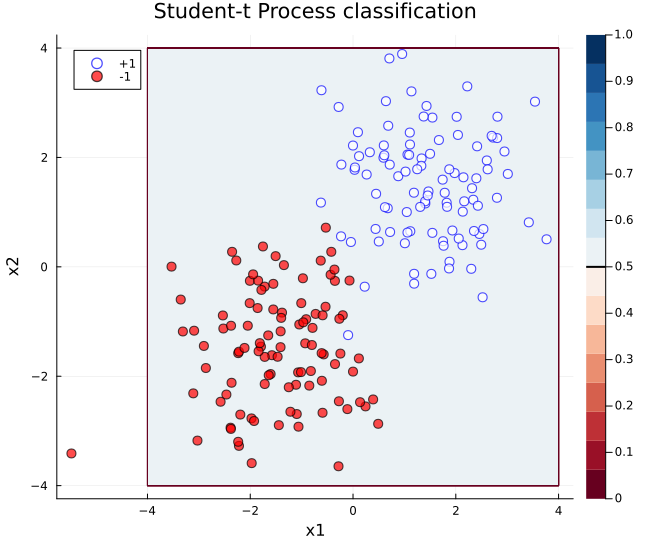

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

┌ Info: EP converged at iteration 1
└ @ Main /home/onoue/ws/RR.jl/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sdnNjb2RlLXJlbW90ZQ==.jl:98


In [1]:
# ============================================================================
# Student‑t Process Classification (EP) – Jupyter single cell (fixed)
# ----------------------------------------------------------------------------
# Paste into a Jupyter cell; safe to re‑run. This version fixes the Dimen­sion
# mismatch in `predict` by using dot products with pre‑computed symmetric
# matrix.
# ============================================================================

using LinearAlgebra
using Random
using Distributions
using Distances           # pairwise(Euclidean(), …)
using Plots

# --------------------------------------------------------
#  RBF (squared-exponential) kernel
# --------------------------------------------------------
function rbf_kernel(X1::Matrix{Float64}, X2::Matrix{Float64};
                    ell::Float64 = 1.0, sigma2::Float64 = 1.0)
    dists = pairwise(Euclidean(), X1', X2')
    return sigma2 .* exp.(-0.5 .* (dists .^ 2) ./ ell^2)
end

# --------------------------------------------------------
#  Model container (guarded so re-runs are safe)
# --------------------------------------------------------
if !isdefined(Main, :STPClassifier)
    mutable struct STPClassifier
        X::Matrix{Float64}
        y::Vector{Float64}
        v::Float64
        ell::Float64
        sigma2::Float64
        K::Matrix{Float64}
        V_f::Matrix{Float64}
        m_f::Vector{Float64}
        tau_tilde::Vector{Float64}
        nu_tilde::Vector{Float64}
    end
end

# --------------------------------------------------------
#  Constructor
# --------------------------------------------------------
function STPClassifier(X::Matrix{Float64}, y::Vector{Float64};
                       v::Float64 = 5.0, ell::Float64 = 1.0, sigma2::Float64 = 1.0)
    @assert size(X,1) == length(y) "X / y size mismatch"
    n = size(X,1)
    K = rbf_kernel(X, X; ell = ell, sigma2 = sigma2) + 1e-6I(n)  # jitter
    return STPClassifier(X, y, v, ell, sigma2, K, copy(K), zeros(n), zeros(n), zeros(n))
end

# --------------------------------------------------------
#  Expectation Propagation
# --------------------------------------------------------
function fit!(model::STPClassifier; max_iter::Int = 50, tol::Float64 = 1e-4,
                                 damping::Float64 = 0.9, eps::Float64 = 1e-3)
    n = length(model.y)
    dist_t = TDist(model.v)
    for iter in 1:max_iter
        m_prev = copy(model.m_f)
        for i in shuffle(1:n)
            # cavity
            V_inv = inv(model.V_f)
            V_cav_inv = copy(V_inv); V_cav_inv[i,i] -= model.tau_tilde[i]
            isposdef(V_cav_inv) || continue
            V_cav = inv(V_cav_inv)
            m_prec = V_inv * model.m_f
            m_cav_prec = copy(m_prec); m_cav_prec[i] -= model.nu_tilde[i]
            m_cav = V_cav * m_cav_prec
            mu_minus = m_cav[i]
            sigma2_minus = V_cav[i,i]
            # moment matching
            z = model.y[i] * mu_minus / sqrt(sigma2_minus)
            cdf_t = cdf(dist_t, z); pdf_t = pdf(dist_t, z)
            Z2 = eps + (1-2eps)*cdf_t; Z2 < 1e-12 && continue
            alpha = (1-2eps)*pdf_t/(Z2*sqrt(sigma2_minus))
            mu_hat = mu_minus + sigma2_minus*alpha*model.y[i]
            sigma2_hat = sigma2_minus*(1 - sigma2_minus*alpha*(model.y[i]*z + alpha*sigma2_minus))
            sigma2_hat = max(sigma2_hat, 1e-8)
            delta_tau = 1/sigma2_hat - 1/sigma2_minus
            delta_nu  = mu_hat/sigma2_hat - mu_minus/sigma2_minus
            new_tau = (1-damping)*model.tau_tilde[i] + damping*(model.tau_tilde[i] + delta_tau)
            new_nu  = (1-damping)*model.nu_tilde[i]  + damping*(model.nu_tilde[i]  + delta_nu)
            # rank-1 update
            e = zeros(n); e[i] = 1.0
            model.V_f = inv(V_inv + (new_tau - model.tau_tilde[i]) * (e*e'))
            model.m_f = model.V_f * (m_prec + (new_nu - model.nu_tilde[i]) * e)
            model.tau_tilde[i] = new_tau; model.nu_tilde[i] = new_nu
        end

        println(model.m_f)
        println(m_prev)
        eval_convergence = norm(model.m_f - m_prev) / max(norm(m_prev), 1e-8)
        println("Iteration $iter: convergence = $eval_convergence")

        if eval_convergence < tol
            @info "EP converged at iteration $iter"; return true
        end
    end
    @warn "EP did not converge"; false
end

# --------------------------------------------------------
#  Prediction (fixed)
# --------------------------------------------------------
function predict(model::STPClassifier, Xnew::Matrix{Float64})
    k_cross = rbf_kernel(Xnew, model.X; ell=model.ell, sigma2=model.sigma2)  # (n_new × n)
    K_inv = inv(model.K)
    mu = k_cross * K_inv * model.m_f

    # pre‑compute symmetric matrix for variance term
    mid = K_inv * (model.V_f - model.K) * K_inv        # (n × n)
    var = similar(mu)
    for j in 1:size(Xnew,1)
        v = view(k_cross, j, :)            # length‑n vector (SubArray)
        var[j] = model.sigma2 + dot(v, mid * v)
        var[j] = max(var[j], 1e-8)
    end
    dist_t = TDist(model.v)
    return cdf.(dist_t, mu ./ sqrt.(var))
end

# --------------------------------------------------------
#  Demo utility
# --------------------------------------------------------
function demo_stp(n_per_class::Int = 100)
    # toy blobs
    X1 = randn(n_per_class, 2) .+ [1.5 1.5]
    X2 = randn(n_per_class, 2) .+ [-1.5 -1.5]
    X = vcat(X1, X2)
    y = vcat(fill(1.0, n_per_class), fill(-1.0, n_per_class))
    model = STPClassifier(X, y, v=5.0, ell=1.0)
    fit!(model, damping=0.9)
    # grid plot
    xr = -4:0.1:4; yr = -4:0.1:4
    grid = reduce(vcat, [[x y] for y in yr for x in xr])
    pred = predict(model, grid)
    Z = reshape(pred, length(yr), length(xr))
    p = contourf(xr, yr, Z, clims=(0,1), c=:RdBu, size=(650,550),
                 xlabel="x1", ylabel="x2", title="Student‑t Process classification")
    contour!(p, xr, yr, Z, levels=[0.5], linewidth=2, color=:black)
    scatter!(p, X[y .== 1.0,1], X[y .== 1.0,2], marker=(:circle,5,0.7,:white,stroke(1,:blue)), label="+1")
    scatter!(p, X[y .== -1.0,1], X[y .== -1.0,2], marker=(:circle,5,0.7,:red), label="-1")
    return p
end

# ---------------------------------------------------------------------------
#  Quick test (comment out to suppress)
# ---------------------------------------------------------------------------
Random.seed!(42)
display(demo_stp())
